In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

# from torchinfo import summary

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import random
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import math



In [45]:
def load_img_steering(datadir, data):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
 

In [46]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1) # one for horizontal flip
    steering_angle =- steering_angle
    return image,steering_angle
    
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [47]:

class DrivingImageDataset(Dataset):
    def __init__(self, image_paths, steering_ang, transform=None):
        self.img_paths = image_paths
        self.steering_angs = steering_ang
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = mpimg.imread(img_path)
        img = img_preprocess(img)
        img = img.astype(np.uint8)
        steering = self.steering_angs[index]

        if self.transform is not None:
            img = self.transform(img)
            # img = img.to(dtype=torch.long)
            steering = torch.tensor(steering)
            steering = torch.tensor([steering.to(dtype=torch.float32)])

        # print('steering: ',steering.shape)
        return img, steering

In [48]:

class nvidia_model(nn.Module):
    in_planes = [3, 24, 36, 48, 64, 64, 1152, 100, 50, 10, 1]
    kernel_size = [5, 5, 5, 3, 3]
    dropout_p = [0.45, 0.4, 0.4]
    def __init__(self):
        super(nvidia_model, self).__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(self.in_planes[0], self.in_planes[1], self.kernel_size[0], stride=2)
        self.conv2 = nn.Conv2d(self.in_planes[1], self.in_planes[2], self.kernel_size[1], stride=2)
        self.conv3 = nn.Conv2d(self.in_planes[2], self.in_planes[3], self.kernel_size[2], stride=2)
        self.conv4 = nn.Conv2d(self.in_planes[3], self.in_planes[4], self.kernel_size[3])
        self.conv5 = nn.Conv2d(self.in_planes[4], self.in_planes[5], self.kernel_size[4])
        self.dropout1 = nn.Dropout(p=self.dropout_p[0])
        self.fc1 = nn.Linear(self.in_planes[6], self.in_planes[7])
        self.dropout2 = nn.Dropout(p=self.dropout_p[1])
        self.fc2 = nn.Linear(self.in_planes[7], self.in_planes[8])
        self.dropout3 = nn.Dropout(p=self.dropout_p[2])
        self.fc3 = nn.Linear(self.in_planes[8], self.in_planes[9])
        self.output = nn.Linear(self.in_planes[9], self.in_planes[10])

    # def print_layer(self, layer):
    #     print(layer.shape)
    #     print(type(layer))

    def forward(self, x):
        # self.print_layer(x)
        out = self.bn1(x)
        # self.print_layer(out)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = self.dropout1(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = F.relu(self.fc2(out))
        out = self.dropout3(out)
        out = F.relu(self.fc3(out))
        out = self.output(out)
        return out



In [49]:
TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
term_width = 80 

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [50]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    # Setup time measurement for training epoch
    _tTrainAcc = 0
    _cnt = 0
    _topAccu = 0
    _tCommAccu = 0
    _tComputeAccu = 0
    _tBegin = time.perf_counter()

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        _tTrainStart = time.perf_counter()
        inputs, targets = inputs.to(device), targets.to(device)
        # print('Finish Copying data into GPU')
        # print('Test: ',targets.shape)
        # print(inputs.dtype)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        _tCommStart = time.perf_counter()
        loss.backward()
        optimizer.step()
        # torch.cuda.synchronize()
        
        _tTrainEnd = time.perf_counter()

        train_loss += loss.item()
        total += targets.size(0)

        if not verboseFlag:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.5f'
                    % (train_loss/(batch_idx+1)))
        _tTrainAcc += _tTrainEnd - _tTrainStart
        _tCommAccu += _tTrainEnd- _tCommStart
        _tComputeAccu += _tCommStart - _tTrainStart

    _tEnd = time.perf_counter()
    totalTime = _tEnd - _tBegin
    trainTime = _tTrainAcc
    commTime = _tCommAccu
    computeTime = _tComputeAccu
    loadTime = totalTime - trainTime
    return train_loss, trainTime, totalTime, loadTime, commTime, computeTime

        



In [51]:
def test(epoch):
    global best_loss
    net.eval()
    test_loss = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            total += targets.size(0)

        if not verboseFlag:
            progress_bar(batch_idx, len(testloader), 'Loss: %.5f'
                    % (test_loss/(batch_idx+1)))

    # Save checkpoint.
    if loss < best_loss:
        print('Saving..')
        state = {
            'net': net.module.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_loss = loss

In [52]:
# model = nvidia_model()
# summary(model, (3,66,200), batch_size=500)

In [53]:
def load_data(datadir):
    columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
    data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
    pd.set_option('display.max_colwidth', None)
    data.head()
    
    num_bins = 25
    samples_per_bin = 800
    hist, bins = np.histogram(data['steering'], num_bins)
    center = (bins[:-1]+bins[1:]) * 0.5
    plt.bar(center, hist, width = 0.05)
    plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))
    
    
    print('total data', len(data))

    remove_list = []
    for j in range(num_bins):
        list_ = []
        for i in range(len(data['steering'])):
            if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
                list_.append(i)
        list_ = shuffle(list_)
        list_ = list_[samples_per_bin:]
        remove_list.extend(list_)
        
    print('removed', len(remove_list))
    data.drop(data.index[remove_list], inplace = True)
    print('remaining', len(data))

    hist, _ = np.histogram(data['steering'], (num_bins))
    plt.bar(center, hist, width = 0.05)
    plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))
    return data

In [54]:

def gen_Dataset(Dir, batch):
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    transform_valid = transforms.Compose([
        transforms.ToTensor()
    ])
    data = load_data(Dir)
    image_paths, steerings = load_img_steering(Dir + '/IMG', data)
    X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2)
    print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
    Q = math.floor(len(X_train)/batch)
    trainset = DrivingImageDataset(X_train, y_train, transform_train)
    testset = DrivingImageDataset(X_valid, y_valid, transform_valid)
    return trainset, testset
    

==> Preparing Data
total data 3042
removed 906
remaining 2136
Training Samples: 5126
Valid Samples: 1282
==> Building Model
Start training using cuda

Epoch: 0
 [==============================================================>..]  Step: 376ms | Tot: 15s855ms | Loss: 0.058 26/26 
 [============================================================>....]  Step: 3s454ms | Tot: 19s309ms | Loss: 0.030 13/13 
Saving..

Epoch: 1
 [==============================================================>..]  Step: 382ms | Tot: 15s227ms | Loss: 0.034 26/26 
 [============================================================>....]  Step: 3s320ms | Tot: 18s547ms | Loss: 0.029 13/13 

Epoch: 2
 [==============================================================>..]  Step: 390ms | Tot: 15s218ms | Loss: 0.032 26/26 
 [============================================================>....]  Step: 3s405ms | Tot: 18s623ms | Loss: 0.028 13/13 
Saving..

Epoch: 3
 [==============================================================>..]  St

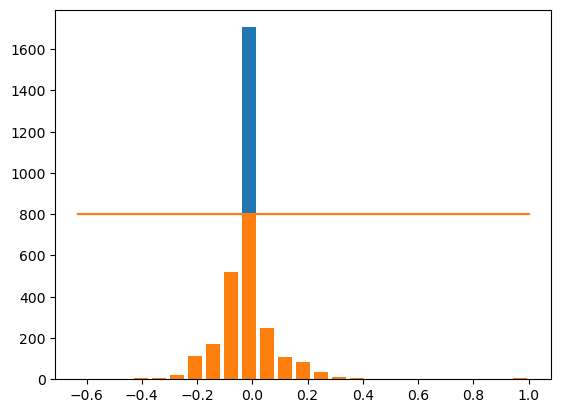

In [55]:

if __name__ == "__main__":
    datadir = '../2'
    verboseFlag = False
    batch = 200
    epochs = 10
    worker_nums = 0
    best_loss = 1000
    print('==> Preparing Data')
    trainset, testset = gen_Dataset(datadir, batch)
    
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size = batch, shuffle=True, num_workers=worker_nums
    )

    testloader = torch.utils.data.DataLoader(
        testset, batch_size = 100, shuffle=True, num_workers=worker_nums
    )

    print('==> Building Model')
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    print('Start training using', device)
        
    net = nvidia_model()
    # net = net.double()
    # summary(net)
    net = net.to(device)
    if device == 'cuda':
        net =torch.nn.DataParallel(net)
        cudnn.benchmark = True
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    loss_list = []
    for epoch in range(0, epochs):
        trainPerf = train(epoch)
        test(epoch)
        scheduler.step()
        loss_list.append(trainPerf[0])

    
    


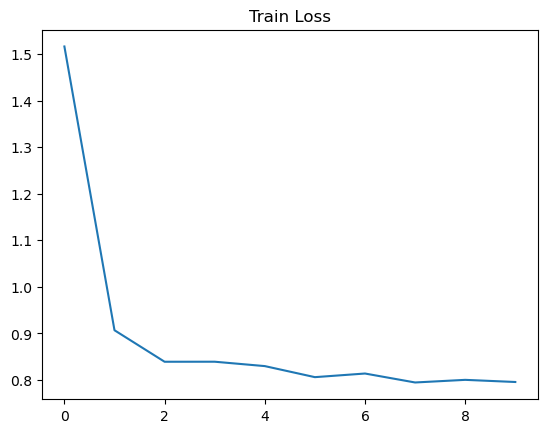

In [56]:
plt.plot(loss_list)
plt.title('Train Loss')
plt.show()